# Spam Detection 
- [Dataset-link](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset)

In [59]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string

In [60]:
# Read the data
df = pd.read_csv("spam.csv")
# df_= pd.read_csv("mail_data.csv") #they are both same dataset
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


## steps

- Data cleaning
- EDA
- Text Preporcessing
- Model Building
- Evaluation
- Inprovement
- Website
- Deploy

In [62]:
df.drop(columns = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace = True)
df.sample(2)

,v1,v2
1825,ham,Wat makes some people dearer is not just de ha...
3417,spam,LIFE has never been this much fun and great un...


## Columns Meaning

* v1 is our label column. Which represent wether the email is spam or not spam.
* v2 column contains the text of the emails.
* Other columns are not important.

### Dropping the unnecessary columns.

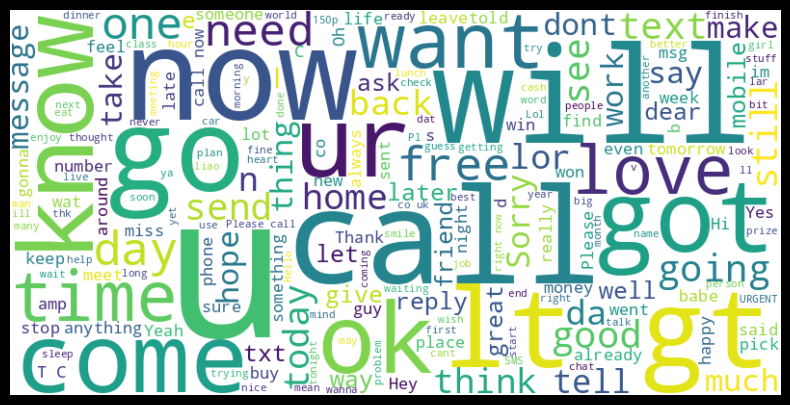

In [63]:
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(''.join(df.v2))

plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [64]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [65]:
df["v1"] = encoder.fit_transform(df["v1"])
df.sample(2)

,v1,v2
5046,0,Hmmm.still we dont have opener?
5213,0,3 pa but not selected.


# checking for missing values

In [66]:
df.isnull().sum()

v1    0
v2    0
dtype: int64

# check for duplicate value

In [67]:
df.duplicated().sum()

403

In [68]:
df = df.drop_duplicates(keep="first")
# df.tail(3)
df.shape

(5169, 2)

# 2.EDA

In [69]:
df["v1"].value_counts()

v1
0    4516
1     653
Name: count, dtype: int64

([<matplotlib.patches.Wedge at 0x7f86d86e05d0>,
 [Text(-1.0144997251399075, 0.42519443516002464, 'ham'),
  Text(1.014499764949479, -0.4251943401757036, 'spam')],
 [Text(-0.5533634864399495, 0.23192423736001339, '87.367'),
  Text(0.5533635081542612, -0.23192418555038377, '12.633')])

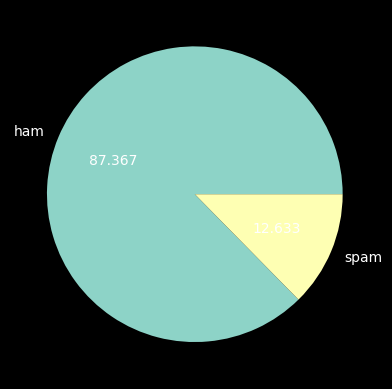

In [70]:
import matplotlib.pyplot as plt
plt.pie(df["v1"].value_counts(), labels=["ham","spam"],autopct="%0.3f")

# DATA IS IMBALANCED !

In [71]:
import nltk
# nltk.download("punkt")

In [72]:
df["num_characters"] = df["v2"].apply(len)
df.sample(3)

,v1,v2,num_characters
2451,0,I know complain num only..bettr directly go to...,74
142,0,A swt thought: \Nver get tired of doing little...,158
1034,0,ZOE IT JUST HIT ME 2 IM FUCKING SHITIN MYSELF ...,103


In [73]:
#break the sentence into indivisual words
df["num_words"] = df["v2"].apply(lambda x:len(nltk.word_tokenize(x)))
df.sample(3)

,v1,v2,num_characters,num_words
1298,0,Your daily text from me ��� a favour this time,46,10
2893,0,K...k...yesterday i was in cbe .,32,10
4899,1,"ou are guaranteed the latest Nokia Phone, a 40...",145,30


In [74]:
df["num_sentences"] = df["v2"].apply(lambda x:len(nltk.sent_tokenize(x)))
df.sample(3)

,v1,v2,num_characters,num_words,num_sentences
3483,0,Tell my bad character which u Dnt lik in me. ...,165,44,4
939,0,Better. Made up for Friday and stuffed myself ...,133,30,4
635,0,Me n him so funny...,20,6,1


In [75]:
#getting more information about the newly made 3 columns
df[["num_characters","num_words","num_sentences"]].describe()

,num_characters,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.924163,18.456761,1.966531
std,58.175349,13.325633,1.449833
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [76]:
# get more info about the ham(not_spam)
df[df["v1"] == 0][["num_characters","num_words","num_sentences"]].describe()

,num_characters,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.457263,17.123782,1.820195
std,56.357463,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [77]:
# get more info about the spam
df[df["v1"] == 1][["num_characters","num_words","num_sentences"]].describe()

,num_characters,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.479326,27.675345,2.978560
std,30.014336,7.011513,1.493185
min,13.000000,2.000000,1.000000
25%,131.000000,25.000000,2.000000
50%,148.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,223.000000,46.000000,9.000000


# Data-Viz

<Axes: xlabel='num_characters', ylabel='Count'>

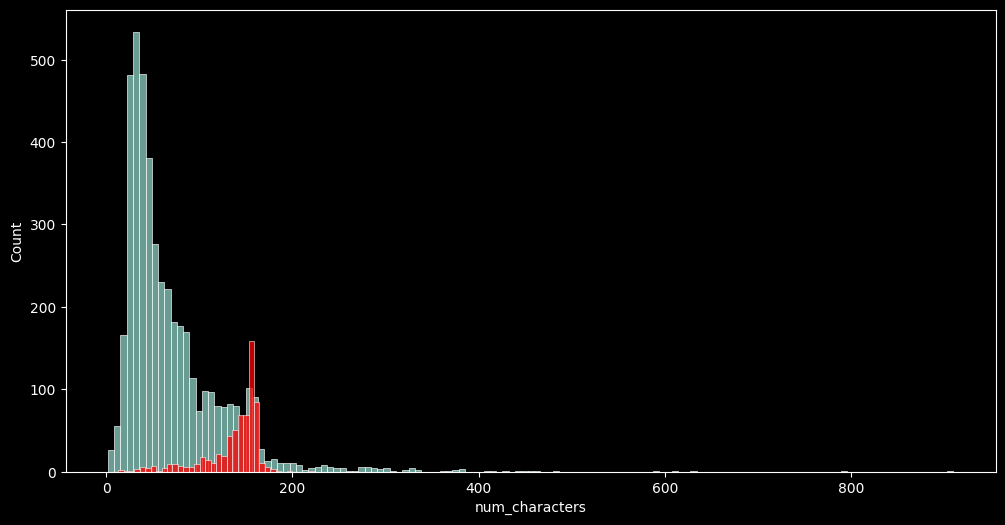

In [78]:
plt.figure(figsize=(12,6))
sns.histplot(df[df["v1"] == 0]["num_characters"])
sns.histplot(df[df["v1"] == 1]["num_characters"],color="red")

<Axes: xlabel='num_words', ylabel='Count'>

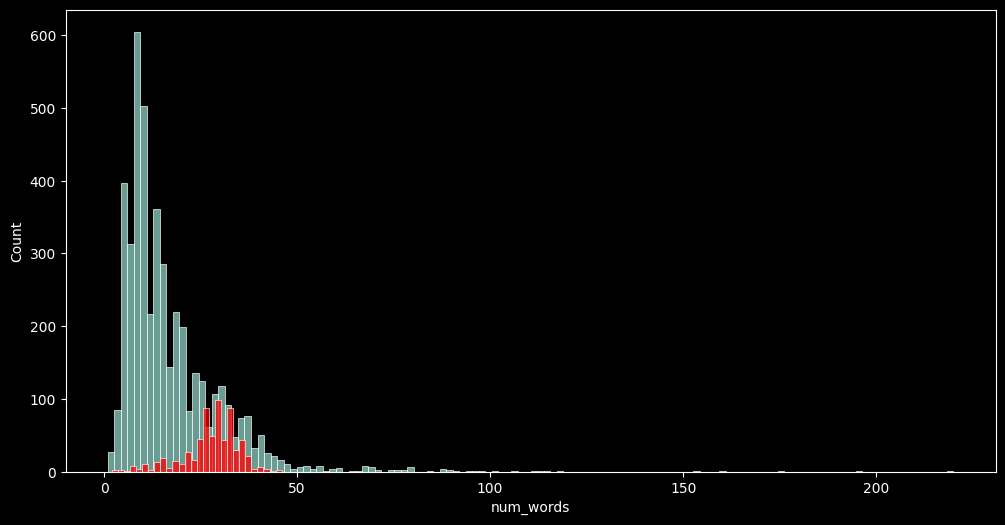

In [79]:
plt.figure(figsize=(12,6))
sns.histplot(df[df["v1"] == 0]["num_words"])
sns.histplot(df[df["v1"] == 1]["num_words"],color="red")

/home/chaos/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


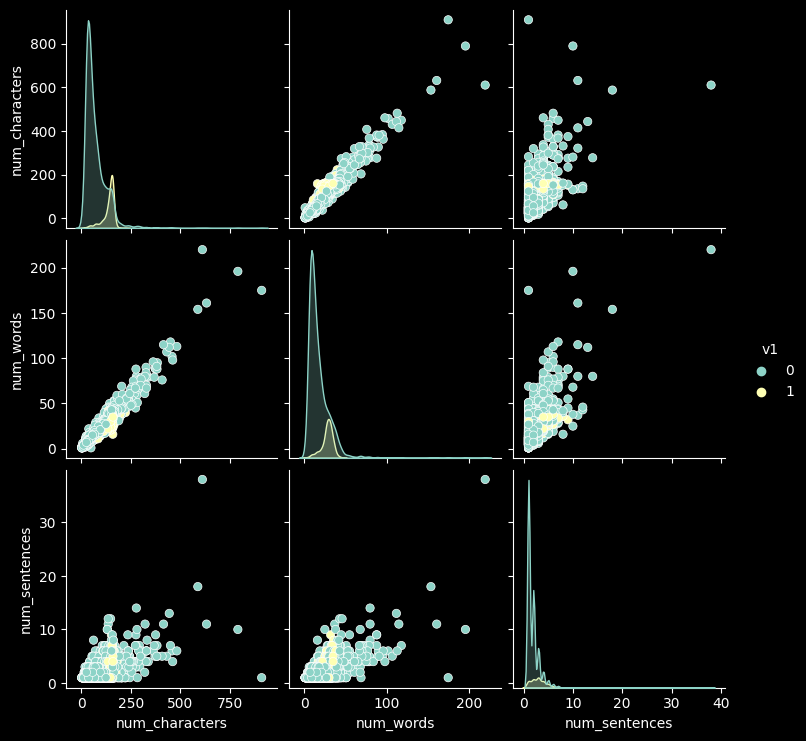

In [80]:
sns.pairplot(df,hue="v1")

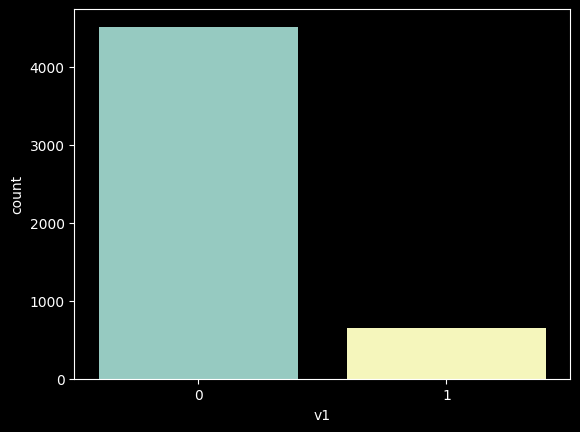

In [81]:
sns.countplot(x='v1', data=df)
plt.show()


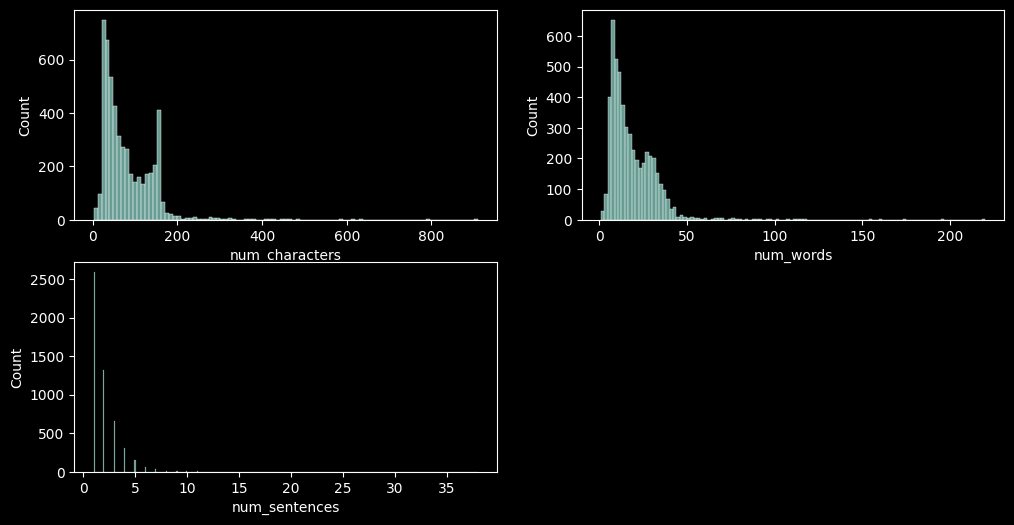

In [82]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
sns.histplot(df['num_characters'])
plt.subplot(2, 2, 2)
sns.histplot(df['num_words'])
plt.subplot(2, 2, 3)
sns.histplot(df['num_sentences'])
plt.show()


# Data Preprocessing
- lower case
- tokenization
- removing special char
- removing stop words and punctuation
- stemming

### Converting email texts into vectors.

In [83]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

text = ['Hello my name is james', 'james this is my python notebook', 'james trying to create a big dataset', 'james of words to try differnt', 'features of count vectorizer']

vectorizer = CountVectorizer(stop_words='english')

count_matrix = vectorizer.fit_transform(text)

count_array = count_matrix.toarray()

df1 = pd.DataFrame(data=count_array, columns=vectorizer.get_feature_names_out())

df1


,big,count,create,dataset,differnt,features,hello,james,notebook,python,try,trying,vectorizer,words
0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,1,1,0,0,0,0
2,1,0,1,1,0,0,0,1,0,0,0,1,0,0
3,0,0,0,0,1,0,0,1,0,0,1,0,0,1
4,0,1,0,0,0,1,0,0,0,0,0,0,1,0


In [84]:
# Remove the stop words and transform the texts into the vectorized input variables X

X = vectorizer.fit_transform(df["v2"])

y = df["v1"]

# Split the data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X.toarray(), y, test_size=0.3, random_state=0)

In [85]:
clf = GaussianNB()

clf.fit(X_train, y_train)

clf.score(X_test, y_test)

0.8949065119277885

In [86]:
# Function to Make Predictions
def predict_spam(input_text):
    text_vectorized = vectorizer.transform([input_text])
    prediction = clf.predict(text_vectorized.toarray())[0]
    return "Spam" if prediction == 1 else "Not Spam"

In [87]:
# !pip install gradio
# !pip install entrypoints

import gradio as gr

# Gradio Interface
iface = gr.Interface(
    fn=predict_spam,
    inputs=gr.Textbox(),
    outputs=gr.Textbox(),
    live=True,
    title="Spam Classifier",
    description="Enter an email text to check if it's spam or not."
)

iface.launch()

Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.
